## 正式赛题——船运到达时间预测
在企业全球化业务体系中，海运物流作为其最重要的一项支撑。其中，船运公司会和数据供应公司进行合作，对运输用的船通过GPS进行定位以监控船的位置；在运输管理的过程中，货物到达目的港的时间是非常重要的一项数据，那么需要通过船运的历史数据构建模型，对目的港到达时间进行预测，预测时间简称为ETA（estimated time of arrival），目的港到达时间预测为ARRIVAL_ETA。
本次大赛提供历史运单GPS数据、历史运单事件数据、港口坐标数据，**预测货物运单的到达时间，对应“历史运单事件”数据中EVENT_CODE字段值为ARRIVAL AT PORT时EVENT_CONVOLUTION_DATE的时间值**。

一、比赛数据
大赛提供脱敏后的训练数据及测试数据，训练数据集包括：历史运单GPS数据、历史运单事件数据、港口坐标数据，这些数据主要用于参赛队伍训练模型，制定预估策略；测试运单数据为不同运单、运输过程中的不同位置所构成，供选手测试对应的ETA时间。
货物运单在船运过程中，会产生大量的GPS运单数据，记录为“历史运单GPS数据”；货物运单在船运过程中离开起运港、到达中转港、到达目的港等关键事件，记录为“历史运单事件数据”；“港口的坐标数据“为与运单船运相关的港口坐标信息。
允许选手合理增加与题目相关的外部数据进行纠正，如大赛提供的港口坐标数据存在偏差时可自行补充数据纠正

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


## 坐标数据描述每个运单在船运的过程中涉及的港口位置信息:
- 港口名称
- 港口的经度坐标
- 港口的纬度坐标
- 国家
- 省|州
- 城市
- 县|区
- 详细地址。
- 港口编码，即港口的字母简码

In [2]:
#港口坐标数据
#港口坐标数据描述每个运单在船运的过程中涉及的港口位置信息。
port=pd.read_csv('../event_port/port.csv')
port.describe()

,LONGITUDE,LATITUDE,PORT_CODE,TRANSPORT_NODE_ID
count,2456.000000,2456.000000,2.500000e+01,2.420000e+03
mean,16.518344,18.550666,3.458640e+07,5.477894e+07
std,71.399595,22.590817,7.384261e+07,7.974048e+07
min,-175.183605,-53.793502,2.462000e+06,1.170000e+05
25%,-3.457919,0.611022,2.576000e+06,2.927750e+06
50%,7.676975,18.432586,3.519000e+06,3.553500e+06
75%,57.510925,37.748396,3.684000e+06,9.520150e+07
max,178.557549,73.212735,2.118270e+08,2.842170e+08


### 历史运单GPS数据
#### 历史运单GPS数据描述每个运单在船运的过程中，所在船产生的GPS位置的相关信息。
- loadingOrder 脱敏后的主运单，货物的运单编号，类似快递单号
- carrierName 脱敏后的承运商名称，类似快递公司名称
- timestamp 时间，格式为：yyyy-MM-dd'T'HH:mm:ss.SSSZ，如2019-09-05T16:33:17.000Z
- longitude 货物在运输过程中，当前船舶所处的经度坐标，如114.234567
- latitude 货物在运输过程中，当前船舶所处的纬度坐标，如21.234567
- vesselMMSI 脱敏后的船舶海上移动业务识别码MMSI， 唯一标识，对应到每一艘船
- speed 单位km/h，货物在运输过程中，当前船舶的瞬时速度，部分数据未提供的可自行计算。
- direction 当前船舶的行驶方向，正北是0度，31480代表西北方向314.80度，900代表正北偏东9度。
- vesselNextport 船舶将要到达的下一港口，港口名称可能不规范，如CNQIN、CN QIN、CN QINGDAO都代表下一站为中国青岛港口。
- vesselNextportETA 船运公司给出的到“下一个港口”预计到达时间，格式为：yyyy-MM-dd'T'HH:mm:ss.SSSZ，如2019-09-12T16:33:17.000Z
- vesselStatus 当前船舶航行状态，主要包括：
  - moored
  - under way using engine
  - not under command
  - at anchor
  - under way sailing
  - constrained by her draught
- vesselDatasource 船舶数据来源（岸基/卫星）：Coastal AIS，Satellite
- TRANSPORT_TRACE  船的路由，由“-”连接组成，例如CNSHK-MYPKG-MYTPP。由承运商预先录入，实际小概率存在不按此路由行驶（如遇塞港时），但最终会到达目的港口。

### 注意!!: 一个运单对应一艘船，一艘船可以对应多个运单

## 一列一列读取GPS数据分析
- 总共147907541条数据
- 运单数量:21157条;相应的event中运单数量15512;因此gps中很多订单是没有event数据的
- 时间库跨度:1.1~4.30总共4个月
- TRANSPORT_TRACE中，有55029818缺失

In [4]:
#gpsdf.shape
#gpsdf.to_csv('gps_sample5kw.csv',index=False)
gpsdf=pd.read_csv('../clean_dataset/dataHasAllXY.csv')
gpsdf.describe()

,longitude,latitude,speed,direction
count,7.194400e+07,7.194400e+07,7.194400e+07,7.194400e+07
mean,5.754967e+01,1.283384e+01,2.180132e+01,2.059113e+04
std,7.017714e+01,2.228892e+01,1.314887e+01,1.009879e+04
min,-1.800000e+02,-5.100285e+01,0.000000e+00,-1.000000e+00
25%,1.550702e+01,1.284487e+00,1.200000e+01,1.120000e+04
50%,7.829897e+01,1.376067e+01,2.700000e+01,2.350000e+04
75%,1.048785e+02,3.090405e+01,3.200000e+01,2.891000e+04
max,1.800000e+02,6.859553e+01,1.890000e+02,5.110000e+04


In [5]:
#对数据进行预处理
def get_data(data, mode='train'):
    
    assert mode=='train' or mode=='test'
    
    if mode=='train':#船舶将要到达的下一个港口的预计时间,转码格式
        pass
    elif mode=='test':
        data['temp_timestamp'] = data['timestamp']#当前时间
        data['onboardDate'] = pd.to_datetime(data['onboardDate'], infer_datetime_format=True)#离开起运港时间
    data['timestamp'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True)
    data['longitude'] = data['longitude'].astype(float)
    data['loadingOrder'] = data['loadingOrder'].astype(str)
    data['latitude'] = data['latitude'].astype(float)
    data['speed'] = data['speed'].astype(float)
    data['direction'] = data['direction'].astype(float)

    return data
gpsdf = get_data(gpsdf, mode='train')
#test_data = get_data(test_data, mode='test')

In [6]:
#预处理特征，得到标签,同时得到起点到终点的距离
#因为寻咯数据是完整轨迹，那么为了和测试数据保持一致，需要为训练数据选取一个截断点cut，只保留截断点之前的数据
import random
from geopy.distance import geodesic
def cut_data(df):
    cut_list=[]
    reserve_list=[]
    #labels=[]
    df.sort_values(['loadingOrder', 'timestamp'], inplace=True)
    sx=[]
    sy=[]
    ex=[]
    ey=[]
    dis=[]
    grouped=df.groupby('loadingOrder')
    for name,group in grouped:
        group=group.reset_index(drop=True)
        s_x=group['longitude'][:1].reset_index(drop=True)[0]
        s_y=group['latitude'][:1].reset_index(drop=True)[0]
        e_x=group['longitude'][-1:].reset_index(drop=True)[0]
        e_y=group['latitude'][-1:].reset_index(drop=True)[0]
        sx.append(s_x)
        sy.append(s_y)
        ex.append(e_x)
        ey.append(e_y)
        dis.append(geodesic((s_y,s_x), (e_y,e_x)).km)
    group_df = grouped['timestamp']#.agg(('mmax','max'))#.reset_index()
    print('finished1...')
    #
    for name,group in group_df:
        reser=int(len(group)*random.choice([0.3,0.4,0.5,0.6,0.7,0.8,0.9]))+1#随机保留一部分轨迹
        reserve=list(group.index[0:reser])
        reserve_list+=reserve
        #label=(df.loc[group.index[-1],'timestamp']-df.loc[group.index[reser-1],'timestamp']).total_seconds()
        #labels.append(label)
    group_df = df.groupby('loadingOrder')['timestamp'].agg([('mmax','max'),('mmin','min')]).reset_index()
    #读取数据的最大值-最小值，即确认时间间隔为label
    labels=list((group_df['mmax'] - group_df['mmin']).dt.total_seconds())
    return labels,reserve_list,sx,sy,ex,ey,dis
#下面只需要保留原始数据cut之前的数据
labels,reserve_list,sx,sy,ex,ey,dis=cut_data(gpsdf)
print(len(gpsdf.loc[reserve_list].loadingOrder.unique()),len(labels),len(gpsdf.loadingOrder.unique()))
gpsdf=gpsdf.loc[reserve_list].reset_index(drop=True)
len(gpsdf.loadingOrder.unique()),gpsdf.shape

finished1...
12148 12148 12148


(12148, (42972416, 7))

In [7]:
import time
from geopy.distance import geodesic

def get_train_feature(df):
    start_time=time.time()
    df.sort_values(['loadingOrder', 'timestamp'], inplace=True)

    df['lat_diff']=df.groupby('loadingOrder')['latitude'].diff(1)
    df['lon_diff']=df.groupby('loadingOrder')['longitude'].diff(1)
    df['k']=df['lat_diff']/df['lon_diff']
    print('finished1...')
    df['speed_diff'] = df.groupby('loadingOrder')['speed'].diff(1)#速度变化量
    df['diff_minutes'] = df.groupby('loadingOrder')['timestamp'].diff(1).dt.total_seconds() // 60#记录之间的间隔时间(单位:s)
    df['a']=df['speed_diff']/df['diff_minutes']
    print('finished2...')
    #同时计算时间间隔，也就是运单抵达"终点"需要的时间,作为标签
    group_df = df.groupby('loadingOrder')['timestamp'].agg([('mmax','max'),('count','count'), ('mmin','min')]).reset_index()

    k=df.groupby('loadingOrder')['k'].agg([('k_max','max'), ('k_mean','mean'), ('k_min','min'),('k_median','median')])
    a=df.groupby('loadingOrder')['a'].agg([('a_max','max'), ('a_mean','mean'), ('a_min','min'),('a_median','median')])
    group_df = group_df.merge(k, on='loadingOrder', how='left')
    group_df = group_df.merge(a, on='loadingOrder', how='left')
    #以经纬,度,速度，方向为基础特征，然后计算最小，最大，均值，终值等统计特性（以运单为单位）
    print('finished3...')
    #在所有的记录中，多少记录是停船状态
    #df['anchor'] = ((df['lat_diff'] <= 0.03) & (df['lon_diff'] <= 0.03)& (df['speed_diff'] <= 0.3) & (df['diff_minutes'] <= 10)).astype(int)
    df['anchor'] = ((df['lat_diff'].abs() <= 0.03) & (df['lon_diff'].abs() <= 0.03)& (df['speed_diff'] <= 0.3) & (df['diff_minutes'] >= 10)).astype(int)

    anchor_df = df.groupby('loadingOrder')['anchor'].agg('sum').reset_index()
    anchor_df.columns = ['loadingOrder', 'anchor_cnt']
    group_df = group_df.merge(anchor_df, on='loadingOrder', how='left')
    #merge回原表，增加一列: 'anchor_cnt'，同时算一下停船的次数占总记录的比例
    group_df['anchor_ratio'] = group_df['anchor_cnt'] / group_df['count']
    print('finished4...')
    agg_function = ['min', 'max', 'mean', 'median']
    agg_col = ['latitude', 'longitude', 'speed', 'direction']
    group = df.groupby('loadingOrder')[agg_col].agg(agg_function).reset_index()
    print('finished5...')
    group.columns = ['loadingOrder'] + ['{}_{}'.format(i, j) for i in agg_col for j in agg_function]
    group_df = group_df.merge(group, on='loadingOrder', how='left')
    end_time=time.time()
    print("花费时间:",end_time-start_time)
    return group_df
#   
train = get_train_feature(gpsdf)
#
train['start_x']=sx
train['start_y']=sy
train['end_x']=ex
train['end_y']=ey
train['dis']=dis
train['label']=np.array(labels)/3600

finished1...
finished2...
finished3...
finished4...
finished5...
花费时间: 85.83543395996094


## 观察训练数据标签的分布
- 最长时间:86.28858796296296 day
- 最短时间:0.0 day
- 平均时间:16.70094809971483 day

## 而测试数据中已知的轨迹长度为：
- 最长时间:16.88171296296296 day
- 最短时间:0.046527777777777786 day
- 平均时间:4.325498415081749 day


最长时间:80.36274305555555 day
最短时间:0.0 day
平均时间:17.472454240105062 day


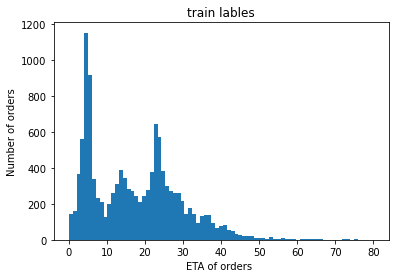

In [8]:
train_label=np.array(train['label']/24)
##观察下预测结果的分布
name_cnt={}#{订单号：对应的事件记录条数}
tmp=[]
print("最长时间:%s day"%(np.max(train_label)))
print("最短时间:%s day"%np.min(train_label))
print("平均时间:%s day"%np.mean(train_label))
#画出分布直方图
import pylab as plt 
bins = np.linspace(int(min(train_label)),int(max(train_label)),int(max(train_label)))
plt.hist(train_label,bins)
plt.xlabel('ETA of orders ')
plt.ylabel('Number of orders')
plt.title('train lables')
plt.show()

In [9]:
train=train[train['label']>0.001*24]#筛选训练样本，0.05天以内的不予考虑
train.shape

(12137, 36)

### 测试运单数据
- loadingOrder 运单的运单号
- timestamp 运单当前所处位置（经度、维度）的时间，格式为：yyyy-MM-dd'T'HH:mm:ss.SSSZ，如2019-09-05T16:33:17.000Z
- longitude 运单承运船舶的当前经度：114.234567 
- latitude 运单承运船舶的当前纬度：21.234567
- speed 货物在运输过程中，当前船舶的瞬时速度，部分数据未提供的可自行计算。
- direction 当前船舶的行驶方向，正北是0度，31480代表西北方向314.80度，900代表正东偏南9度。
- carrierName 承运商名称，类似快递公司名称
- vesselMMSI 脱敏后的船舶海上移动业务识别码MMSI， 唯一标识，对应到每一艘船
- onboardDate 离开起运港时间，格式为：yyyy/MM/dd HH:mm:ss（dd与HH之间为两个空格），如2019/09/05 16:33:17
- TRANSPORT_TRACE 船的路由，由“-”连接组成，例如CNSHK-MYPKG-MYTPP。由承运商预先录入，实际小概率存在不按此路由行驶（如遇塞港时），但最终会到达目的港口。

In [10]:
test_data_pathB='../R2 ATest 0711.csv'
test_data=pd.read_csv(test_data_pathB)
test_data=get_data(test_data, mode='test')
test_data.head()

,loadingOrder,timestamp,longitude,latitude,speed,direction,carrierName,vesselMMSI,onboardDate,TRANSPORT_TRACE,temp_timestamp
0,QM149151037282,2019-01-11 04:18:28+00:00,114.337167,22.556333,28.0,10680.0,UQCRKD,Q4197827697,2019-01-11 04:18:28,CNYTN-NZAKL,2019-01-11T04:18:28.000Z
1,QM149151037282,2019-01-11 04:39:08+00:00,114.426632,22.508475,30.0,13140.0,UQCRKD,Q4197827697,2019-01-11 04:18:28,CNYTN-NZAKL,2019-01-11T04:39:08.000Z
2,QM149151037282,2019-01-11 06:05:48+00:00,114.418000,22.182000,27.0,22210.0,UQCRKD,Q4197827697,2019-01-11 04:18:28,CNYTN-NZAKL,2019-01-11T06:05:48.000Z
3,QM149151037282,2019-01-11 08:48:28+00:00,114.101650,22.314968,15.0,4420.0,UQCRKD,Q4197827697,2019-01-11 04:18:28,CNYTN-NZAKL,2019-01-11T08:48:28.000Z
4,QM149151037282,2019-01-11 09:50:58+00:00,114.123500,22.324167,0.0,7310.0,UQCRKD,Q4197827697,2019-01-11 04:18:28,CNYTN-NZAKL,2019-01-11T09:50:58.000Z


In [11]:
def convert_name_xy(name):#输入港口名称
    port_name=port[port['TRANS_NODE_NAME'].isin([name])].reset_index()
    return port_name['LONGITUDE'][0],port_name['LATITUDE'][0]#返回港口经纬度
#  
start_x=[]#起点
start_y=[]#起点
end_x=[]#终点
end_y=[]#终点
#存储中间结果,避免重复计算
temp_dic={}
for value in test_data['TRANSPORT_TRACE']:
    s_e=value.split('-')
    start_port=s_e[0]
    end_port=s_e[-1]
    if start_port in temp_dic:
        re=temp_dic[start_port]
    else:
        re=convert_name_xy(value.split('-')[0])
        temp_dic[start_port]=re
    start_x.append(re[0])
    start_y.append(re[1])
    if end_port in temp_dic:
        re=temp_dic[end_port]
    else:
        re=convert_name_xy(value.split('-')[-1])
        temp_dic[end_port]=re
    end_x.append(re[0])
    end_y.append(re[1])
test_data['start_x']=start_x
test_data['start_y']=start_y
test_data['end_x']=end_x
test_data['end_y']=end_y

In [12]:
#temp_dic

In [13]:
import time
from geopy.distance import geodesic
def get_test_feature(df):
    start_time=time.time()
    df.sort_values(['loadingOrder', 'timestamp'], inplace=True)
    # 特征只选择经纬度、速度\方向
    dis=[]
    #df['dis'] = df.apply(lambda x: geodesic((x['start_y'],x['start_x']), (x['end_y'],x['end_x'])).km, axis=1)
    #for i in ranngedf['start_x']
    grouped=df.groupby('loadingOrder')
    dis=[]
    start_x=[]
    start_y=[]
    end_x=[]
    end_y=[]
    for _,group in grouped:
        tmp=group[['start_x','start_y','end_x','end_y']][:1].reset_index(drop=True)
        start_x.append(tmp['start_x'][0])
        start_y.append(tmp['start_y'][0])
        end_x.append(tmp['end_x'][0])
        end_y.append(tmp['end_y'][0])
        dis.append(geodesic((tmp['start_y'][0],tmp['start_x'][0]),(tmp['end_y'][0],tmp['end_x'][0])).km)
    df['lat_diff']=df.groupby('loadingOrder')['latitude'].diff(1)
    df['lon_diff']=df.groupby('loadingOrder')['longitude'].diff(1)
    df['k']=df['lat_diff']/df['lon_diff']
    print('finished1...')
    df['speed_diff'] = df.groupby('loadingOrder')['speed'].diff(1)#速度变化量
    df['diff_minutes'] = df.groupby('loadingOrder')['timestamp'].diff(1).dt.total_seconds() // 60#记录之间的间隔时间(单位:s)
    df['a']=df['speed_diff']/df['diff_minutes']
    #
    group_df = df.groupby('loadingOrder')['timestamp'].agg([('mmax','max'),('count','count'), ('mmin','min')]).reset_index()
    #这里的label表示测试集中给了多少天的轨迹数据
    group_df['label']=(group_df['mmax'] - group_df['mmin']).dt.total_seconds()/3600
    k=df.groupby('loadingOrder')['k'].agg([('k_max','max'), ('k_mean','mean'), ('k_min','min'),('k_median','median')])
    a=df.groupby('loadingOrder')['a'].agg([('a_max','max'), ('a_mean','mean'), ('a_min','min'),('a_median','median')])
    group_df = group_df.merge(k, on='loadingOrder', how='left')
    group_df = group_df.merge(a, on='loadingOrder', how='left')
    #在所有的记录中，多少记录是停船状态
    df['anchor'] = ((df['lat_diff'].abs() <= 0.03) & (df['lon_diff'].abs() <= 0.03)& (df['speed_diff'] <= 0.3) & (df['diff_minutes'] >= 10)).astype(int)
    anchor_df = df.groupby('loadingOrder')['anchor'].agg('sum').reset_index()
    anchor_df.columns = ['loadingOrder', 'anchor_cnt']
    group_df = group_df.merge(anchor_df, on='loadingOrder', how='left')
    #merge回原表，增加一列: 'anchor_cnt'，同时算一下停船的次数占总记录的比例
    group_df['anchor_ratio'] = group_df['anchor_cnt'] / group_df['count']
    print('finished3...')
    #以经纬,度,速度，方向为基础特征，然后计算最小，最大，均值，终值等统计特性（以运单为单位）
    agg_function = ['min', 'max', 'mean', 'median']
    agg_col = ['latitude', 'longitude', 'speed', 'direction']
    group = df.groupby('loadingOrder')[agg_col].agg(agg_function).reset_index()
    print('finished4...')
    group.columns = ['loadingOrder'] + ['{}_{}'.format(i, j) for i in agg_col for j in agg_function]
    group_df = group_df.merge(group, on='loadingOrder', how='left')
    group_df['start_x']=start_x
    group_df['start_y']=start_y
    group_df['end_x']=end_x
    group_df['end_y']=end_y
    group_df['dis']=dis
    end_time=time.time()
    print("花费时间:",end_time-start_time)
    return group_df
test=get_test_feature(test_data)

finished1...
finished3...
finished4...
花费时间: 0.6123332977294922


## 观察下测试集中给了多少天的轨迹数据
- 最长时间:16.88171296296296 day
- 最短时间:0.046527777777777786 day
- 平均时间:4.325498415081749 day

最长时间:26.122685185185187 day
最短时间:0.004050925925925926 day
平均时间:2.5039671063757822 day


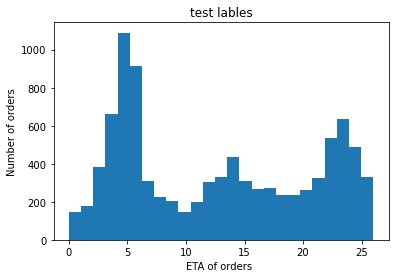

In [14]:
#观察下测试集中给了多少天的轨迹数据
test_label=np.array(test['label']/24)
##观察下预测结果的分布
name_cnt={}#{订单号：对应的事件记录条数}
tmp=[]
print("最长时间:%s day"%(np.max(test_label)))
print("最短时间:%s day"%np.min(test_label))
print("平均时间:%s day"%np.mean(test_label))
#画出分布直方图
import pylab as plt 
bins = np.linspace(int(min(test_label)),int(max(test_label)),int(max(test_label)))
plt.hist(train_label,bins)
plt.xlabel('ETA of orders ')
plt.ylabel('Number of orders')
plt.title('test lables')
plt.show()

In [15]:
test.drop('label',axis=1,inplace=True)
#train.to_csv('train.csv', index=False)
#test.to_csv('test.csv', index=False)
#train=pd.read_csv('train.csv')
#test=pd.read_csv('test.csv')
train.shape,test.shape

((12137, 36), (219, 35))

In [16]:
features = [c for c in train.columns if c not in ['loadingOrder', 'label', 'mmin', 'mmax','k_min','a_min','direction_min','anchor_cnt']]
#features

In [17]:
#train['label']=np.log1p(train['label'])
#train[['count','dis','direction_median','direction_mean','direction_max']]=np.log1p(train[['count','dis','direction_median','direction_mean','direction_max']])

In [18]:
#test[['count','dis','direction_median','direction_mean','direction_max']]=np.log1p(test[['count','dis','direction_median','direction_mean','direction_max']])

## 搭建训练模型

## xgb+lgb

In [19]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,explained_variance_score
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
#from featexp import get_univariate_plots#用于特征筛选，需要先安装featexp
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [20]:
train.shape,test.shape

((12137, 36), (219, 35))

In [21]:
train_data=train[features]
y=train['label']
train_data.shape

(12137, 28)

In [22]:
x_train,x_test,y_train,y_test=train_test_split(train_data,y,test_size=0.1,random_state=2020)

In [23]:
llf=gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=0.1,
                        n_estimators=600)

llf.fit(x_train,y_train)
# 网格搜索，参数优化
'''
estimator = lgb.LGBMRegressor(num_leaves=31)
param_grid = {
    'learning_rate': np.linspace(0.1,0.5,3),
    'n_estimators': [100*i for i in range(1,10)],
}
llf = GridSearchCV(estimator, param_grid)
llf.fit(x_train, y_train)
print('Best parameters found by grid search are:', llf.best_params_)
'''

llf_val_mse=mean_squared_error(y_test,llf.predict(x_test))
llf_train_mse=mean_squared_error(y_train,llf.predict(x_train))
print('val_mse:','{:e}'.format(llf_val_mse))
print('train_mse:','{:e}'.format(llf_train_mse))

val_mse: 6.447885e+03
train_mse: 4.791750e+02


In [24]:
cv_params = {'n_estimators': [400, 500, 600, 700, 800]}
other_params = {'learning_rate': 0.05, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

xlf = xgb.XGBRegressor(**other_params)
xlf.fit(x_train,y_train)
xlf_val_mse=mean_squared_error(y_test,xlf.predict(x_test))
xlf_train_mse=mean_squared_error(y_train,xlf.predict(x_train))
print('val_mse:','{:e}'.format(xlf_val_mse))
print('train_mse:','{:e}'.format(xlf_train_mse))
#optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
#optimized_GBM.fit(train_data, y)
#evalute_result = optimized_GBM.grid_scores_
#print('每轮迭代运行结果:{0}'.format(evalute_result))
#print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
#print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

val_mse: 6.375277e+03
train_mse: 4.154470e+02


In [25]:
details=[]
answers=np.zeros(len(test))
n_splits=5
cnt=0
sk=KFold(n_splits=n_splits,shuffle=True,random_state=2020)
for train_k,test_k in sk.split(train_data,y):
    cnt+=1
    x_train=train_data.iloc[train_k]
    y_train=y.iloc[train_k]
    x_test=train_data.iloc[test_k]
    y_test=y.iloc[test_k]
    
    xlf.fit(x_train,y_train)
    pred_xgb=xlf.predict(x_test)
    weight_xgb=mean_squared_error(y_test,pred_xgb)
    
    llf.fit(x_train,y_train)
    pred_llf=llf.predict(x_test)
    weight_lgb=mean_squared_error(y_test,pred_llf)
    
    
    prob_xgb=xlf.predict(x_test)
    prob_lgb=llf.predict(x_test)
    
    errors=[]
    ij=[]
    weight=np.arange(0,1.05,0.1)
    for i,item in enumerate(weight):
        prob_end=prob_xgb*item+prob_lgb*(1-item)
        error=mean_squared_error(y_test,prob_end)
        errors.append(error)
        ij.append((item,1-item))
    
    ii=ij[np.argmin(errors)][0]
    jj=ij[np.argmin(errors)][1]
    
    details.append(min(errors))
    details.append(weight_xgb)
    details.append(weight_lgb)
    details.append(ii)
    details.append(jj)

    print("第%d次验证mse误差为%f" %(cnt,min(errors)))
   
    test_xgb=xlf.predict(test[features])
    test_lgb=llf.predict(test[features])
    ans=test_xgb*ii+test_lgb*jj
    
    answers+=ans/n_splits

第1次验证mse误差为5284.674640
第2次验证mse误差为3954.280932
第3次验证mse误差为5367.293285
第4次验证mse误差为4233.425893
第5次验证mse误差为4737.864688


## 观察训练/验证过程

In [26]:
#观察训练/验证过程
df=pd.DataFrame(np.array(details).reshape(int(len(details)/5),5)
                ,columns=['test_end_score','xgboost','lightgbm','weight_xgboost','weight_lightgbm',])
df

,test_end_score,xgboost,lightgbm,weight_xgboost,weight_lightgbm
0,5284.674640,5300.963384,5699.082993,0.8,0.2
1,3954.280932,4048.380414,4266.207881,0.6,0.4
2,5367.293285,5385.005052,5839.539134,0.8,0.2
3,4233.425893,4243.589545,4806.185427,0.9,0.1
4,4737.864688,4890.239576,4955.264014,0.5,0.5


## 观察预测结果的分布

预测的最长时间:38.94155130118619 day
预测的最短时间:1.6265700219252468 day
预测的平均时间:19.27223800510642 day


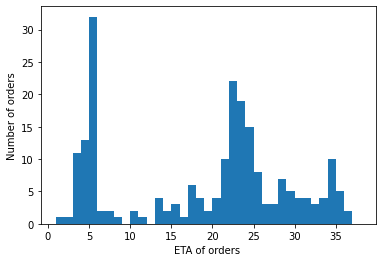

In [27]:
##观察下预测结果的分布
re_day=answers/24
name_cnt={}#{订单号：对应的事件记录条数}
tmp=[]
print("预测的最长时间:%s day"%(np.max(re_day)))
print("预测的最短时间:%s day"%np.min(re_day))
print("预测的平均时间:%s day"%np.mean(re_day))
#画出分布直方图
import pylab as plt 
bins = np.linspace(int(min(re_day)),int(max(re_day)),int(max(re_day)))
plt.hist(re_day,bins)
plt.xlabel('ETA of orders ')
plt.ylabel('Number of orders')
plt.show()

预测的最长时间:41.53280218409299 day
预测的最短时间:0.7503500481643698 day
预测的平均时间:15.602533636239563 day


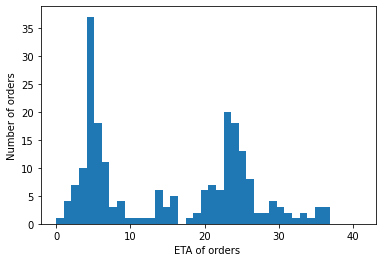

<function matplotlib.pyplot.close(fig=None)>

In [28]:
sub11025=np.load('../submit/11025.npy')
##观察下预测结果的分布
re_day=sub11025/24
name_cnt={}#{订单号：对应的事件记录条数}
tmp=[]
print("预测的最长时间:%s day"%(np.max(re_day)))
print("预测的最短时间:%s day"%np.min(re_day))
print("预测的平均时间:%s day"%np.mean(re_day))
#画出分布直方图
import pylab as plt 
bins = np.linspace(int(min(re_day)),int(max(re_day)),int(max(re_day)))
plt.hist(re_day,bins)
plt.xlabel('ETA of orders ')
plt.ylabel('Number of orders')
plt.show()
plt.close

In [30]:
print("answer与sub11025的mse:%.0f"%mean_squared_error(answers,sub11025))

answer与sub11025的mse:44041


## 特征重要度筛选

<Figure size 1296x648 with 0 Axes>

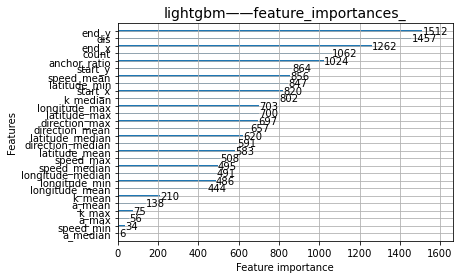

In [31]:
plt.figure(figsize=(18,9))
lgb.plot_importance(llf,max_num_features=29)
plt.title('lightgbm——feature_importances_',fontsize=14)
plt.show()

<Figure size 1296x648 with 0 Axes>

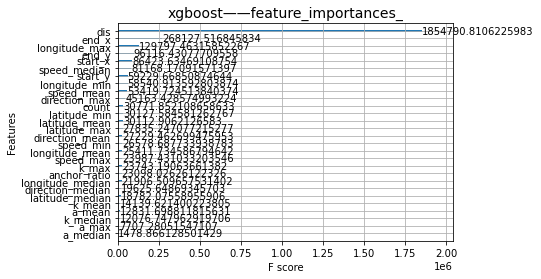

In [32]:
plt.figure(figsize=(18,9))
xgb.plot_importance(xlf,max_num_features=29,importance_type='gain')#'gain'可以换成weight
plt.title('xgboost——feature_importances_',fontsize=14)
plt.show()

Text(0.5, 1.0, 'xgboost&lightgbm——feature_importances_')

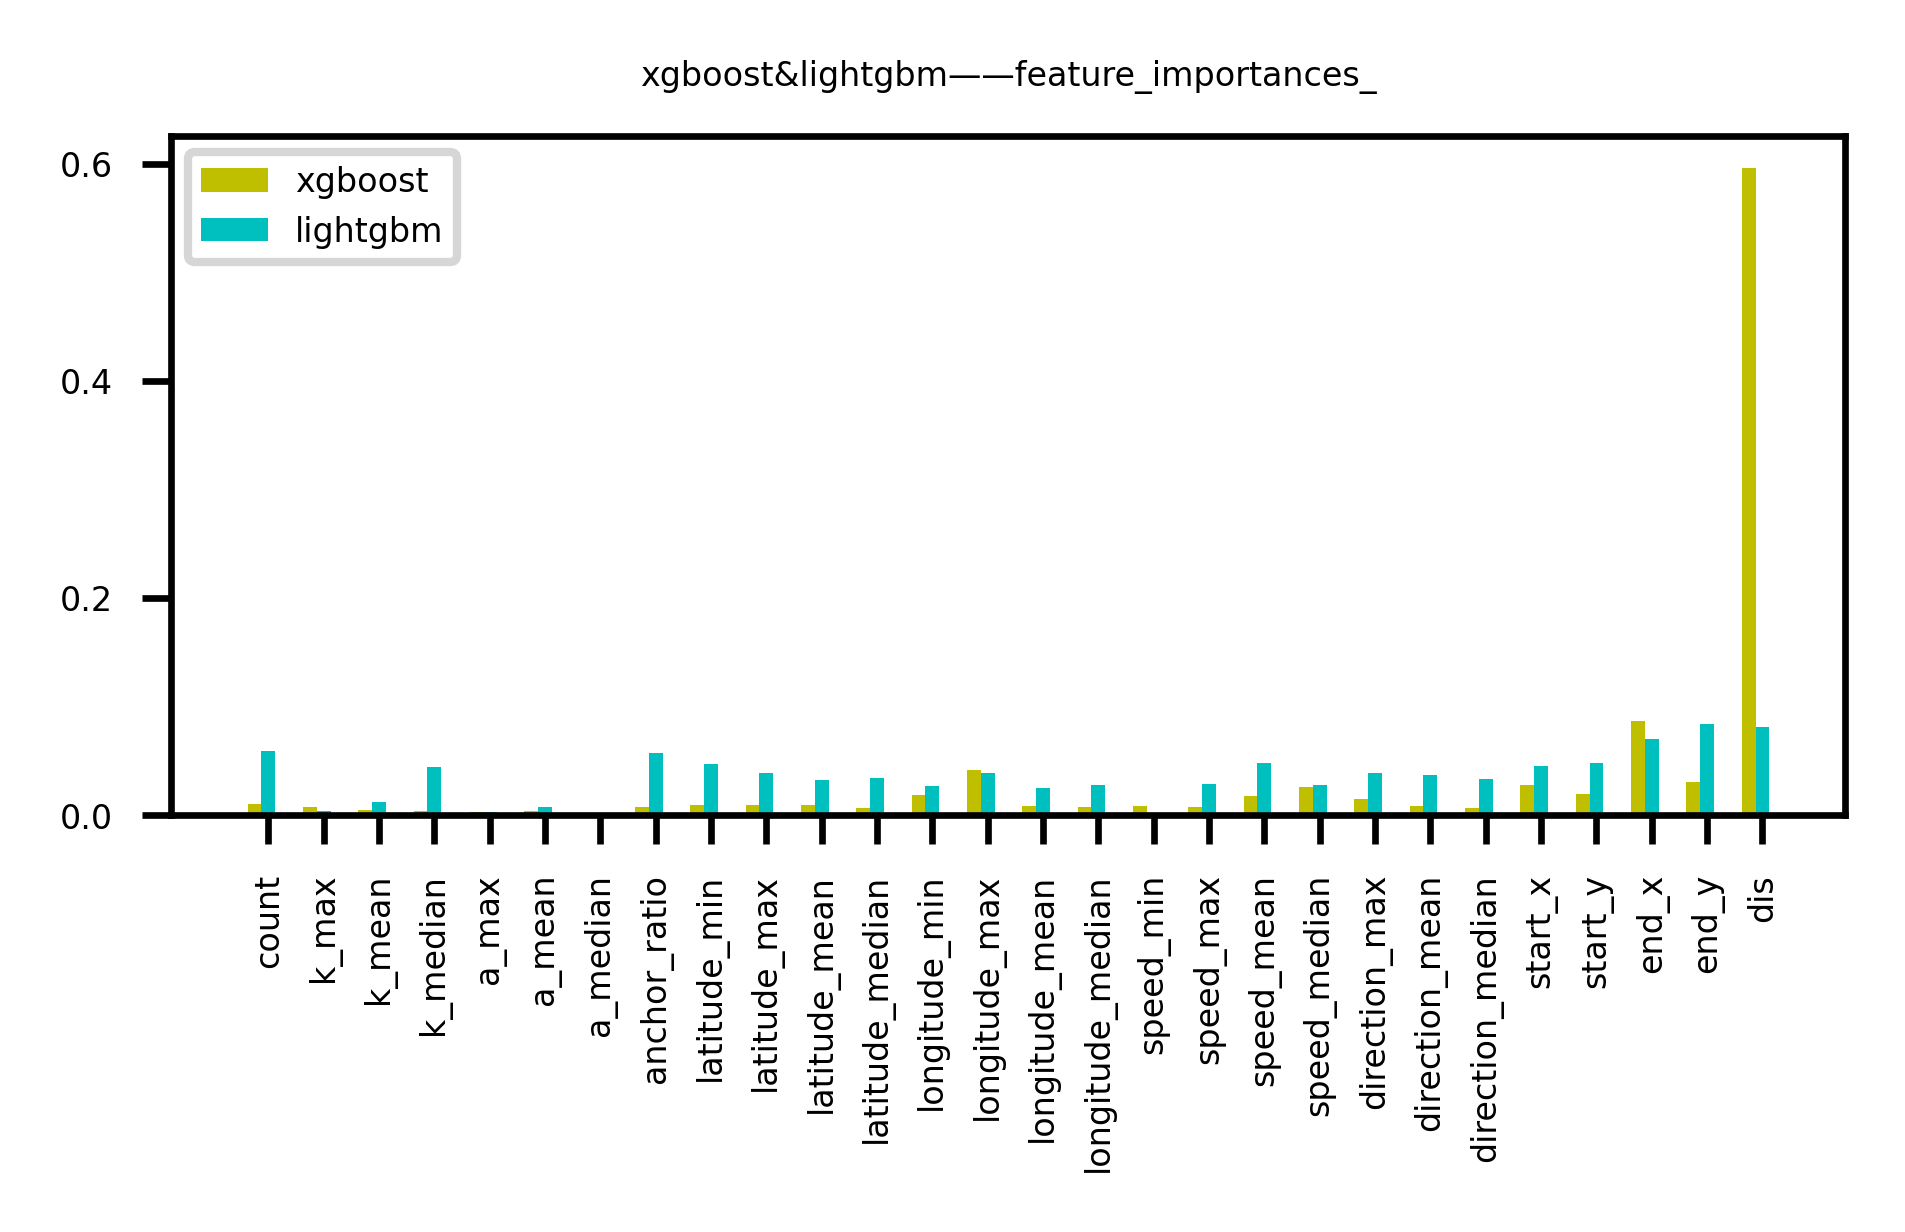

In [33]:
width=0.25
address=np.arange(len(train_data.columns))
tick_label=train_data.columns
plt.figure(dpi=600,figsize=(3.6,1.5))
plt.bar(address
        ,xlf.feature_importances_
        ,width
        ,color='y'
        ,label='xgboost')
plt.bar(address+width
        ,llf.feature_importances_/sum(llf.feature_importances_)
        ,width
        ,color='c'
        ,label='lightgbm')
plt.legend(fontsize=4)
plt.xticks(address+width
           ,tick_label
           ,fontsize=4
           ,rotation=90
           ,horizontalalignment='center')
plt.yticks(fontsize=4,rotation=0)
plt.title('xgboost&lightgbm——feature_importances_',fontsize=4)

## 生成提交文件

In [169]:
test['label'] = answers
result=test[['loadingOrder', 'label']]
test_data_path = 'A_testData0531.csv'
test_data=pd.read_csv(test_data_path)
test_data=get_data(test_data, mode='test')
#
test_data = test_data.merge(result, on='loadingOrder', how='left')
test_data['ETA'] = (test_data['onboardDate'] + test_data['label'].apply(lambda x:pd.Timedelta(hours=x))).apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
test_data.drop(['direction','TRANSPORT_TRACE'],axis=1,inplace=True)
test_data['onboardDate'] = test_data['onboardDate'].apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
test_data['creatDate'] = pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')
test_data['timestamp'] = test_data['temp_timestamp']
# 整理columns顺序
submit = test_data[['loadingOrder', 'timestamp', 'longitude', 'latitude', 'carrierName', 'vesselMMSI', 'onboardDate', 'ETA', 'creatDate']]

In [170]:
submit

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
0,CF946210847851,2019-04-02T02:42:28.000Z,138.471062,40.278787,OIEQNT,R5480015614,2019/04/02 02:42:28,2019/04/24 05:11:26,2020/06/10 16:33:35
1,CF946210847851,2019-04-02T02:59:28.000Z,138.552168,40.327785,OIEQNT,R5480015614,2019/04/02 02:42:28,2019/04/24 05:11:26,2020/06/10 16:33:35
2,CF946210847851,2019-04-02T03:07:28.000Z,138.588250,40.352542,OIEQNT,R5480015614,2019/04/02 02:42:28,2019/04/24 05:11:26,2020/06/10 16:33:35
3,CF946210847851,2019-04-02T03:43:28.000Z,138.751325,40.459447,OIEQNT,R5480015614,2019/04/02 02:42:28,2019/04/24 05:11:26,2020/06/10 16:33:35
4,CF946210847851,2019-04-02T04:29:28.000Z,138.969782,40.581485,OIEQNT,R5480015614,2019/04/02 02:42:28,2019/04/24 05:11:26,2020/06/10 16:33:35
...,...,...,...,...,...,...,...,...,...
45451,XG479584941731,2019-01-13T03:56:08.000Z,104.633357,1.630708,JCMFTA,U2218600548,2019/01/10 00:27:58,2019/02/04 22:49:32,2020/06/10 16:33:35
45452,XG479584941731,2019-01-13T03:57:08.000Z,104.631958,1.626713,JCMFTA,U2218600548,2019/01/10 00:27:58,2019/02/04 22:49:32,2020/06/10 16:33:35
45453,XG479584941731,2019-01-13T03:57:38.000Z,104.631258,1.624615,JCMFTA,U2218600548,2019/01/10 00:27:58,2019/02/04 22:49:32,2020/06/10 16:33:35
45454,XG479584941731,2019-01-13T03:58:08.000Z,104.630597,1.622682,JCMFTA,U2218600548,2019/01/10 00:27:58,2019/02/04 22:49:32,2020/06/10 16:33:35


In [171]:
submit.to_csv('result6_11v1.csv', index=False)